# 第5章 Logistic回归

利用Logistic回归进行分类的主要思想是：根据现有数据对分类边界线建立回归公式，以此进行分类。这里的“回归”一词源于最佳拟合，表示要找到最佳拟合参数集，其背后的数学分析将在下一部分介绍。训练分类器时的做法就是寻找最佳拟合参数，使用的是最优化算法。接下来介绍这个二值型输出分类器的数学原理。

**Logistic回归的一般过程**
1. 收集数据：采用任意方法收集数据
2. 准备数据：由于需要进行距离计算，因此要求数据类型为数值型。另外，结构化数据格式则最佳
3. 分析数据：采用任意方法对数据进行分析
4. 训练算法：大部分时间将用于训练，训练的目的是为了找到最佳的分类回归系数
5. 测试算法：一旦训练步骤完成，分类将会很快
6. 使用算法：首先，我们需要一些输入数据，并将其转换成对应的结构化数值；接着，基于训练好的回归系数就可以对这些数值进行简单的回归计算，判定它们属于哪个类别；在这之后，我们就可以在输出的类别上做一些其他分析工作

## 5.1 基于Logistic回归和Sigmoid函数的分类
> Logistic回归
> 
> 优点：计算代价不高，易于理解和实现
>
> 缺点：容易欠拟合，分类精度可能不高
>
> 适用数据类型：数值型和标称型数据

我们想要的函数应该是，能接受所有的输入然后预测出类别。例如，在两个类的情况下，上述函数输出0或1。具有这种性质的函数称为海维塞德阶跃函数（Heaviside step function），或者单位阶跃函数。然而，海维塞德阶跃函数的问题在于：该函数在跳跃点上从0瞬间跳跃到1，这个瞬间跳跃过程有时很难处理。幸好，另一个函数也有类似的性质且数学上更易处理，这就是Sigmoid函数：

$\sigma(z) = \frac{1}{1+e^{-z}}$

下图是不同参数对应的Sigmoid函数。当x为0时，Sigmoid函数值为0.5。随着x的增大，对应的Sigmoid值将逼近于1；而随着x的减小，Sigmoid值将逼近于0。如果横坐标刻度足够大，Sigmoid函数将看起来很像一个阶跃函数：
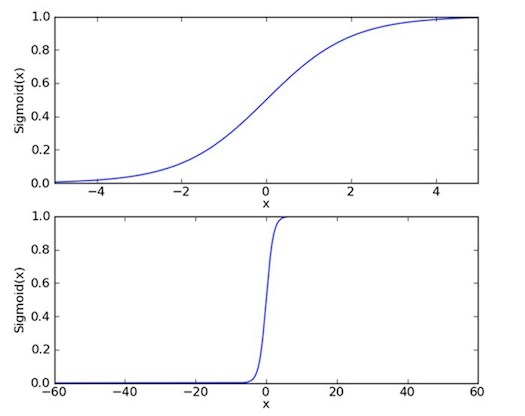

**图5-1、两种坐标尺度下的Sigmoid函数图。上图的横坐标为-5到5，这时的曲线变化较为平滑；下图横坐标的尺度足够大，可以看到，在x = 0点处Sigmoid函数看起来很像阶跃函数**

因此，为了实现Logistic回归分类器，我们可以在每个特征上乘以一个回归系数，然后把所有的结果值相加，将这个总和代入Sigmoid函数中，进而得到一个范围在0~1之间的数值。最后，结果大于0.5的数据被归入1类，小于0.5的即被归入0类。所以，Logistic回归也可以被看成是一种概率估计。

## 5.2 基于最优化方法的最佳回归系数确定
Sigmoid函数的输入记为$z$，由下面公式得出：

$z = w_0x_0 + w_1x_2 + w_2x_2 + ... + w_nx_n$

采用向量的写法：

$z = W^TX$

### 5.2.1 梯度上升法
梯度上升法基于的思想是：要找到某函数的最大值，最好的方法是沿着该函数的梯度方向探寻。如果梯度记为$\nabla$，则函数$f(x,y)$的梯度由下式表示：

$\nabla f(x,y) = \begin{pmatrix}
        \frac{\partial f(x,y)}{\partial x} \\
        \frac{\partial f(x,y)}{\partial y} \\
        \end{pmatrix}$

其中，函数$f(x,y)$必须要在待计算的点上有定义并且可微。一个具体的函数例子见下图：
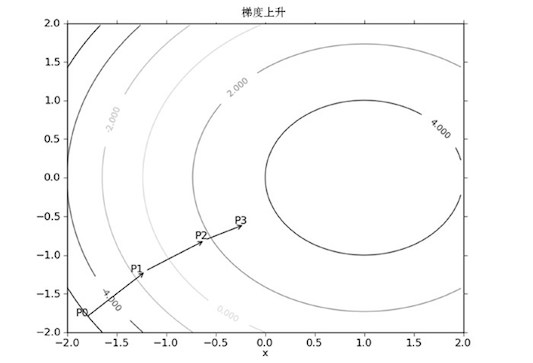

**图5-2、梯度上升算法到达每个点后都会重新估计移动的方向。从P0开始，计算完该点的梯度，函数就根据梯度移动到下一点P1。在P1点，梯度再次被重新计算，并沿新的梯度方向移动到P2。如此循环迭代，直到满足停止条件。迭代的过程中，梯度算子总是保证我们能选取到最佳的移动方向**

设步长为$\alpha$，用向量来表示的话，梯度上升算法的迭代公式如下：

$w := w + \alpha \nabla_w f(w)$

该公式将一直被迭代执行，直至达到某个停止条件为止，比如迭代次数达到某个指定值或算法达到某个可以允许的误差范围。

> **梯度下降算法**
> 梯度下降算法用来求函数的最小值，公式如下：
>
> $w := w - \alpha \nabla_w f(w)$

### 5.2.2 训练算法：使用梯度上升找到最佳参数
梯度上升法的伪代码如下：
```
每个回归系数初始化为1
重复R次：
    计算整个数据集的梯度
    使用`alpha × gradient`更新回归系数的向量
    返回回归系数
```

具体实现如下：

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import random

# 可视化测试数据
def displayDataSet(dataset):
    x = []
    y = []
    labels = []
    fr = open(dataset)
    for line in fr.readlines():
        lineArr = line.strip().split()
        x.append(float(lineArr[0]))
        y.append(float(lineArr[1]))
        labels.append(int(lineArr[2]))
    fig = plt.gcf().set_size_inches(10, 5)
    plt.scatter(x, y, c = labels, cmap=plt.cm.coolwarm, alpha = 0.5)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

# 加载测试数据
def loadDataSet(dataset):
    dataMat = []; labelMat = []
    fr = open(dataset)
    for line in fr.readlines():
        lineArr = line.strip().split()
        # 为了方便计算，我们将 X0 的值设为 1.0 ，也就是在每一行的开头添加一个 1.0 作为 X0
        dataMat.append([1.0, float(lineArr[0]), float(lineArr[1])])
        labelMat.append(int(lineArr[2]))
    return dataMat,labelMat

def sigmoid(inX):
    return 1.0/(1+np.exp(-inX))

# 梯度上升
def gradAscent(dataMatIn, classLabels):
    # 转换为NumPy矩阵数据类型 
    dataMatrix = np.mat(dataMatIn)
    labelMat = np.mat(classLabels).transpose()
    m,n = np.shape(dataMatrix)
    alpha = 0.001
    maxCycles = 500
    weights = np.ones((n,1))
    for k in range(maxCycles):
        # 矩阵相乘
        h = sigmoid(dataMatrix*weights)
        error = (labelMat - h)
        weights = weights + alpha * dataMatrix.transpose()* error
    return weights

我们首先用散点图观察一下要分类的数据：

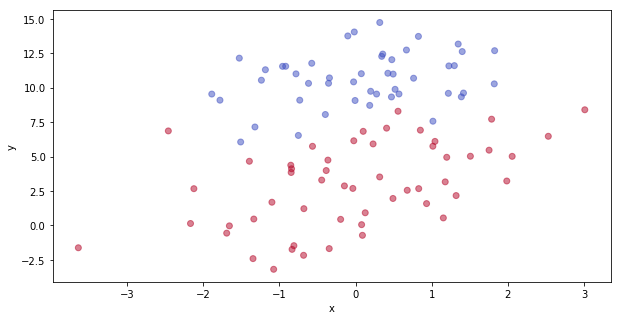

In [2]:
displayDataSet('data/testSet.txt')

测试梯度下降算法：

In [3]:
dataArr,labelMat = loadDataSet('data/testSet.txt')
weights = gradAscent(dataArr, labelMat)
weights

matrix([[ 4.12414349],
        [ 0.48007329],
        [-0.6168482 ]])

### 5.2.3 分析数据：画出决策边界
根据上面的决策参数，我们可视化分割线：

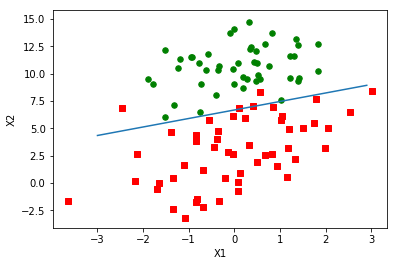

In [4]:
def plotBestFit(weights):
    dataMat, labelMat=loadDataSet('data/testSet.txt')
    dataArr = np.array(dataMat)
    n = np.shape(dataArr)[0] 
    xcord1 = []; ycord1 = []
    xcord2 = []; ycord2 = []
    for i in range(n):
        if int(labelMat[i])== 1:
            xcord1.append(dataArr[i,1])
            ycord1.append(dataArr[i,2])
        else:
            xcord2.append(dataArr[i,1])
            ycord2.append(dataArr[i,2])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(xcord1, ycord1, s=30, c='red', marker='s')
    ax.scatter(xcord2, ycord2, s=30, c='green')
    x = np.arange(-3.0, 3.0, 0.1)
    # 假设sigmoid函数为0。参考Sigmoid函数图，0是两个类别的分界处。因此，我们设定0 = w0x0 + w1x1 + w2x2
    # 然后解出X2和X1的关系式（即分隔线的方程，注意X0=1）。
    y = (-weights[0]-weights[1]*x)/weights[2]
    ax.plot(x, y)
    plt.xlabel('X1')
    plt.ylabel('X2');
    plt.show()

# getA()将weights矩阵转换为数组，getA()函数与mat()函数的功能相反  
# 如果是矩阵的话会报这样的错： 
# ValueError: x and y must have same first dimension, but have shapes (60,) and (1, 60) 
# 为啥要用数组呢？因为 x = arange(-3.0, 3.0, 0.1)，len(x) = [3-(-3)]/0.1 = 60 
# 而weights是矩阵的话，y = (-weights[0]-weights[1]*x)/weights[2]，len(y) = 1，有60个x，y只有一个，你这样都画不了线 
# 而weights是数据的话，len(y) = 60  
plotBestFit(weights.getA())

### 5.2.4 训练算法：随机梯度上升
梯度上升算法在每次更新回归系数时都需要遍历整个数据集，如果有数十亿样本和成千上万的特征，那么该方法的计算复杂度就太高了。一种改进方法是一次仅用一个样本点来更新回归系数，该方法称为`随机梯度上升算法`。由于可以在新样本到来时对分类器进行增量式更新，因而随机梯度上升算法是一个在线学习算法。

随机梯度上升算法可以写成如下的伪代码：
```
所有回归系数初始化为1  
对数据集中每个样本
    计算该样本的梯度  
    使用alpha × gradient更新回归系数值  
返回回归系数值   
```

随机梯度上升算法与梯度上升算法在代码上很相似，但也有一些区别：
1. 后者的变量$h$和误差$error$都是向量，而前者则全是数值
2. 前者没有矩阵的转换过程，所有变量的数据类型都是NumPy数组

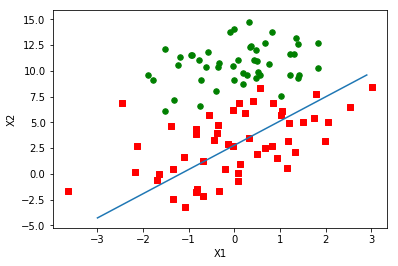

In [5]:
def stocGradAscent0(dataMatrix, classLabels):
    m,n = np.shape(dataMatrix)
    alpha = 0.01
    weights = np.ones(n)
    for i in range(m):
        h = sigmoid(sum(dataMatrix[i]*weights))
        error = classLabels[i] - h
        weights = weights + alpha * error * dataMatrix[i]
    return weights

weights = stocGradAscent0(np.array(dataArr),labelMat)
plotBestFit(weights)

执行完毕后将得到最佳拟合直线图，这里的分类器错分了三分之一的样本。

直接比较程序随机梯度下降和梯度下降的结果是不公平的，后者的结果是在整个数据集上迭代了500次才得到的。一个判断优化算法优劣的可靠方法是看它是否收敛，也就是说参数是否达到了稳定值，是否还会不断地变化？对此，我们在随机梯度上升算法上做了些修改，使其在整个数据集上运行200次。最终绘制的三个回归系数的变化情况如下图所示：
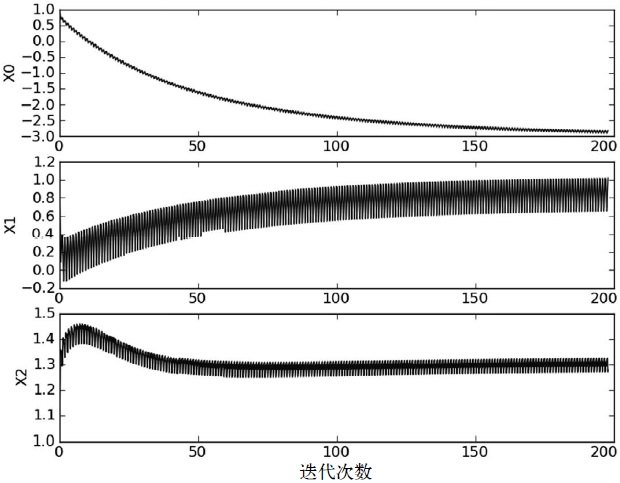

上图展示了随机梯度上升算法在200次迭代过程中回归系数的变化情况。其中的系数2，也就是图中的X2只经过了50次迭代就达到了稳定值，但系数1和0则需要更多次的迭代。另外值得注意的是，在大的波动停止后，还有一些小的周期性波动。不难理解，产生这种现象的原因是存在一些不能正确分类的样本点（数据集并非线性可分），在每次迭代时会引发系数的剧烈改变。我们期望算法能避免来回波动，从而收敛到某个值。另外，收敛速度也需要加快。

对于图中存在的问题，可以通过修改随机梯度上升算法来解决，具体代码如下：

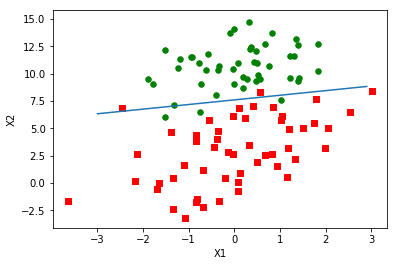

In [12]:
def stocGradAscent1(dataMatrix, classLabels, numIter=150):
    m,n = np.shape(dataMatrix)
    weights = np.ones(n)
    for j in range(numIter):          
        dataIndex = list(range(m))
        for i in range(m):
            #❶  alpha每次迭代时需要调整
            alpha = 4/(1.0+j+i)+0.01
            #❷  随机选取更新 
            randIndex = int(random.uniform(0,len(dataIndex)))
            h = sigmoid(sum(dataMatrix[randIndex]*weights))
            error = classLabels[randIndex] - h
            weights = weights + alpha * error * dataMatrix[randIndex]
            del(dataIndex[randIndex])
    return weights

weights = stocGradAscent1(np.array(dataArr),labelMat)
plotBestFit(weights)

第一处改进在❶处。一方面，alpha在每次迭代的时候都会调整，这会缓解图中的数据波动或者高频波动。另外，虽然alpha会随着迭代次数不断减小，但永远不会减小到0，这是因为❶中还存在一个常数项。必须这样做的原因是为了保证在多次迭代之后新数据仍然具有一定的影响。如果要处理的问题是动态变化的，那么可以适当加大上述常数项，来确保新的值获得更大的回归系数。另一点值得注意的是，在降低alpha的函数中，alpha每次减少$1/(j+i)$ ，其中j是迭代次数，i是样本点的下标1 。这样当$j<<max(i)$时，alpha就不是严格下降的。避免参数的严格下降也常见于模拟退火算法等其他优化算法中。

第二个改进的地方在❷处，这里通过随机选取样本来更新回归系数，这种方法将减少周期性的波动。